In [1]:
import segmentation_models_pytorch as smp

import torch

if __name__ == "__main__":
    import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",  # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,  # model output channels (number of classes in your dataset)
)
x = torch.randn(1, 3, 256, 256)
                                                            
y = model(x)

print(y.shape)

torch.Size([1, 1, 256, 256])


In [1]:
from tqdm import tqdm
from torch import optim
import torch.utils.data
import torch.nn as nn
from detection import *
from utils import CellImageLoad
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import cv2

import argparse
import random
import os
from utils import local_maxima, show_res, optimum, target_peaks_gen, remove_outside_plot




def eval_net_img(
    net, dataset, save_dir,epoch,gpu=True, vis=None, vis_im=None, vis_gt=None, loss=nn.MSELoss()
):
    criterion = loss
    net.eval()
    losses = 0
    torch.cuda.empty_cache()
    
    
    
    if epoch % 500 == 0:
        for iteration, data in enumerate(dataset):
            img = data["image"]
            target = data["gt"]
            if gpu:
                img = img.cuda()
                target = target.cuda()

            pred_img = net(img)
            

           



            pred_img = pred_img.detach().cpu().numpy()
            pred_img=np.clip(pred_img,0,255)
            cv2.imwrite("{}/conf_epoch_{}_iter_{}.tif".format(save_dir,epoch,iteration), (img.detach().cpu().numpy() * 255).astype(np.uint8)[0].transpose(1, 2, 0))
            cv2.imwrite("{}/conf_gt_epoch_{}_iter_{}.tif".format(save_dir,epoch,iteration), (target.detach().cpu().numpy() * 255).astype(np.uint8)[0].transpose(1, 2, 0))
            cv2.imwrite("{}/conf_eval_epoch_{}_iter_{}.tif".format(save_dir,epoch,iteration), (pred_img * 255).astype(np.uint8)[0, 0])
            
    for iteration, data in enumerate(dataset):
        
        img = data["image"]
        target = data["gt"]
        if gpu:
            img = img.cuda()
            target = target.cuda()

        pred_img = net(img)
        
        loss = criterion(pred_img, target)
        losses += loss.data
        
        
        
    return losses / (iteration + 1)


def save_history(loss,val_loss, result_file):
        
    nb_epoch = len(loss)

    with open(result_file, "w") as fp:
        fp.write("epoch\tloss\tval_loss\n")
        for i in range(nb_epoch):
            fp.write("%d\t%f\t%f\n" % (i, loss[i], val_loss[i]))
            
            
def save_history_F(val_F, result_file):
        
    nb_epoch = len(loss)

    with open(result_file, "w") as fp:
        fp.write("epoch\tval_F\n")
        for i in range(nb_epoch):
            fp.write("%d\t%f\t%f\n" % (i, val_F[i],val_F[i]))
def parse_args():
    """
    Parse input arguments
    """
    parser = argparse.ArgumentParser(description="Train data path")
    parser.add_argument(
        "-d",
        "--data_path",
        dest="data_path",
        help="training dataset's path",
        default="./crop/σ=6/sarcoma_train",
        type=str,
    )
    parser.add_argument(
        "-v",
        "--val_path",
        dest="val_path",
        help="validation data path",
        default="./crop/σ=6/sarcoma_val",
        type=str,
    )
    parser.add_argument(
        "-w",
        "--weight_path",
        dest="weight_path",
        help="save weight path",
        default="./crop/σ=6/weight/nuclei_σ=6/best.pth",
    )
    parser.add_argument(
        "-g",
        "--gpu",
        dest="gpu",
        help="whether use CUDA",
        default=True,
        action="store_true",
    )
    parser.add_argument(
        "-b", "--batch_size", dest="batch_size", help="batch_size", default=3, type=int
    )
    parser.add_argument(
        "-e", "--epochs", dest="epochs", help="epochs", default=1000, type=int
    )
    parser.add_argument(
        "-l",
        "--learning_rate",
        dest="learning_rate",
        help="learning late",
        default=1e-3,
        type=float,
    )

    args = parser.parse_args()
    return args


class TrainNet:
    def __init__(self, args):
        data_loader = CellImageLoad(args.tra_img_paths, args.tra_gt_paths)
        self.train_dataset_loader = torch.utils.data.DataLoader(
            data_loader, batch_size=args.batch_size, shuffle=True, num_workers=0
        )
        self.number_of_traindata = data_loader.__len__()

        data_loader = CellImageLoad(args.val_img_paths, args.val_gt_paths)
        
        #validationのバッチサイズを1にしている
        self.val_loader = torch.utils.data.DataLoader(
            data_loader, batch_size=1, shuffle=False, num_workers=0
        )

        self.save_weight_path = args.weight_path
        self.save_weight_path_F=args.weight_path_F
        
        self.save_img_path = args.img_path
        
        
        self.save_weight_path.parent.mkdir(parents=True, exist_ok=True)
        self.save_weight_path.parent.joinpath("epoch_weight").mkdir(
            parents=True, exist_ok=True
        )
        print(
            "Starting training:\nEpochs: {}\nBatch size: {} \nLearning rate: {}\ngpu:{}\n".format(
                args.epochs, args.batch_size, args.learning_rate, args.gpu
            )
        )

        self.net = net

        self.train = None
        self.val = None

        self.N_train = None
        self.optimizer = optim.Adam(net.parameters(), lr=args.learning_rate)
        self.epochs = args.epochs
        self.batch_size = args.batch_size
        self.gpu = args.gpu
        self.criterion = nn.MSELoss()
        self.losses = []
        self.val_losses = []
        
        self.val_Fs = []
        self.evals = []
        self.epoch_loss = 0
        self.epoch_F=0
        self.bad = 0
        
        self.ori_path = args.val_path / Path("ori")
        self.gt_path = args.val_path / Path("likeli")
        
        self.peak_thresh=100
        self.dist_peak=2
        self.dist_threshold=20

    def gather_path(self, train_paths, mode):
        ori_paths = []
        for train_path in train_paths:
            ori_paths.extend(sorted(train_path.joinpath(mode).glob("*.*")))
        return ori_paths

    def show_graph(self):
        x = list(range(len(self.losses)))
        plt.plot(x, self.losses)
        plt.plot(x, self.val_losses)
        plt.savefig(os.path.join(args.img_path, 'loss.png'))
        plt.show()
        plt.close()
        
        return self.losses,self.val_losses
    
    
    def show_graph_F(self):
        x = list(range(len(self.val_Fs)))
        
        plt.plot(x, self.val_Fs)
        
        plt.savefig(os.path.join(args.img_path, 'val_F.png'))
        plt.show()
        plt.close()
        
        return self.val_Fs
        

    def loss_calculate(self, masks_probs_flat, true_masks_flat):
        
        return self.criterion(masks_probs_flat, true_masks_flat)
    
    def pred(self, ori):
        img = ori.astype(np.float32) / ori.max()
        
        

        with torch.no_grad():
            
            
            img = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0)
#            
           
            
            if self.gpu:
                img = img.cuda()
                
            
            mask_pred = self.net(img)
        
        
        pre_img = mask_pred.detach().cpu().numpy()[0, 0]
        #pre_img 0-
        pre_img=np.clip(pre_img,0,1.0)
        
        
        pre_img = (pre_img * 255).astype(np.uint8)
        
        return pre_img

    def main(self):
        
        
        
        for epoch in range(self.epochs):
            net.train()
            tps = 0
            fps = 0
            fns = 0
            path_x = sorted(self.ori_path.glob("*.*"))
            path_y = sorted(self.gt_path.glob("*.*"))

            z = zip(path_x, path_y)
            
            
    
            print("Starting epoch {}/{}.".format(epoch + 1, self.epochs))

#             pbar = tqdm(total=self.number_of_traindata)
            for i, data in enumerate(self.train_dataset_loader):
                imgs = data["image"]
                true_masks = data["gt"]
                

                if self.gpu:
                    imgs = imgs.cuda()
                    true_masks = true_masks.cuda()
                    
                

                masks_pred = self.net(imgs)
                
                

                masks_probs_flat = masks_pred.view(-1)
                
                
                true_masks_flat = true_masks.view(-1)

                loss = self.loss_calculate(masks_probs_flat, true_masks_flat)
                
                
                self.epoch_loss += loss.item()

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

#                 pbar.update(self.batch_size)


            self.net.eval()
            # path def
            
            

            for i, b in enumerate(z):
                import gc
                

                gc.collect()
                ori = cv2.imread(str(b[0]))

                gt_img = cv2.imread(str(b[1]), 0)

                pred_img = self.pred(ori)

                gt = target_peaks_gen((gt_img).astype(np.uint8))
                res = local_maxima(pred_img, self.peak_thresh, self.dist_peak)

                associate_id = optimum(gt, res, self.dist_threshold)
                
                associate_id = np.array(associate_id,dtype='int')
                
                

                gt_final, no_detected_id = remove_outside_plot(
                    gt, associate_id, 0, pred_img.shape
                )
                res_final, overdetection_id = remove_outside_plot(
                    res, associate_id, 1, pred_img.shape
                )


                tp = associate_id.shape[0]
                fn = gt_final.shape[0] - associate_id.shape[0]
                fp = res_final.shape[0] - associate_id.shape[0]
                tps += tp
                fns += fn
                fps += fp

            if tps == 0:
                f_measure = 0
                precision=0
                recall=0
            else:
                recall = tps / (tps + fns)
                precision = tps / (tps + fps)
            if recall==0 and precision==0:
                f_measure-=0
            else:
                f_measure = (2 * recall * precision) / (recall + precision)

            print(precision, recall, f_measure)
            
            
            if epoch==0:
                Max_F=0
            else:
                Max_F=max(self.val_Fs)
                
                
            if Max_F < f_measure:
                print("update best F_measure")
                torch.save(self.net.state_dict(), str(self.save_weight_path_F))
                
            else:
                print('do not update F_measure')
                
            self.val_Fs.append(f_measure)
            
                    

                
            #confirm the data during training
            log_dir='{}/train_img'.format(self.save_img_path)
            if not os.path.exists(log_dir):
                os.makedirs(log_dir)

            if epoch % 50 == 0:
                net.eval()
                pred_img = masks_pred.detach().cpu().numpy()
                pred_img=np.clip(pred_img,0,255)
                cv2.imwrite("{}/conf_epoch_{}_iter_{}.tif".format(log_dir,epoch,i), (imgs.detach().cpu().numpy() * 255).astype(np.uint8)[0].transpose(1, 2, 0))
                cv2.imwrite("{}/conf_gt_epoch_{}_iter_{}.tif".format(log_dir,epoch,i), (true_masks.detach().cpu().numpy() * 255).astype(np.uint8)[0].transpose(1, 2, 0))
                cv2.imwrite("{}/conf_eval_epoch_{}_iter_{}.tif".format(log_dir,epoch,i), (pred_img * 255).astype(np.uint8)[0, 0])
#             pbar.close()
            self.validation(i, epoch)

            if self.bad >= 1000:
                print("stop running")
                break

        loss,val_loss=self.show_graph()
        
        val_F=self.show_graph_F()
        return loss,val_loss, val_F

    def validation(self, number_of_train_data, epoch):
        loss = self.epoch_loss / (number_of_train_data + 1)
        print("Epoch finished ! Loss: {}".format(loss))

        self.losses.append(loss)
        if epoch % 50 == 0:
            torch.save(
                self.net.state_dict(),
                str(
                    self.save_weight_path.parent.joinpath(
                        "epoch_weight/{:05d}.pth".format(epoch)
                    )
                ),
            )
            
        #trainに使用しているデータの保存用
            
        save_dir='{}/val_img'.format(self.save_img_path)
        
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        val_loss = eval_net_img(self.net, self.val_loader,save_dir,epoch,gpu=self.gpu)
        if loss < 0.1:
            print("val_loss: {}".format(val_loss))
            try:
                if min(self.val_losses) > val_loss:
                    print("update best")
                    torch.save(self.net.state_dict(), str(self.save_weight_path))
                    self.bad = 0
                    
                
                else:
                    self.bad += 1
                    print("bad ++")
            except ValueError:
                torch.save(self.net.state_dict(), str(self.save_weight_path))
            self.val_losses.append(val_loss)
            
        else:
            print("loss is too large. Continue train")
            self.val_losses.append(val_loss)
            
        print("bad = {}".format(self.bad))
        self.epoch_loss = 0
        
        
        
        return 



        

D
Starting training:
Epochs: 1001
Batch size: 3 
Learning rate: 0.001
gpu:True

Starting epoch 1/1001.
0.02023121387283237 0.042682926829268296 0.027450980392156862
update best F_measure
Epoch finished ! Loss: 0.2612671762704849
loss is too large. Continue train
bad = 0
Starting epoch 2/1001.
0.006508592990492511 0.8028455284552846 0.012912505516418494
do not update F_measure
Epoch finished ! Loss: 0.030759300291538238
val_loss: 22.866378784179688
update best
bad = 0
Starting epoch 3/1001.
0.016564729867482163 0.13238289205702647 0.02944507361268403
update best F_measure
Epoch finished ! Loss: 0.017070172727108
val_loss: 0.5614805221557617
update best
bad = 0
Starting epoch 4/1001.
0 0 0
do not update F_measure
Epoch finished ! Loss: 0.013863819465041161
val_loss: 0.17466852068901062
update best
bad = 0
Starting epoch 5/1001.
0.011467889908256881 0.010183299389002037 0.010787486515641856
do not update F_measure
Epoch finished ! Loss: 0.01282574124634266
val_loss: 0.020056767389178276
u

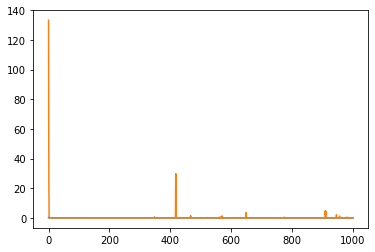

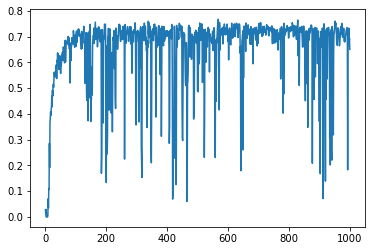

E
Starting training:
Epochs: 1001
Batch size: 3 
Learning rate: 0.001
gpu:True

Starting epoch 1/1001.
0.008137097768462581 0.191027496382055 0.015609294625436055
update best F_measure
Epoch finished ! Loss: 0.4029099777340889
loss is too large. Continue train
bad = 0
Starting epoch 2/1001.
0.009219174480764175 0.7612156295224313 0.018217712049319434
update best F_measure
Epoch finished ! Loss: 0.050903879851102826
val_loss: 165.6870574951172
bad ++
bad = 1
Starting epoch 3/1001.
0.011113710809546092 0.5499276410998553 0.021787116933749965
update best F_measure
Epoch finished ! Loss: 0.0217910997569561
val_loss: 0.38954851031303406
update best
bad = 0
Starting epoch 4/1001.
0.027851458885941646 0.15195369030390737 0.04707464694014795
update best F_measure
Epoch finished ! Loss: 0.016785186901688575
val_loss: 0.0324338935315609
update best
bad = 0
Starting epoch 5/1001.
0.01319034852546917 0.17800289435600578 0.024560702875399364
do not update F_measure
Epoch finished ! Loss: 0.01395890

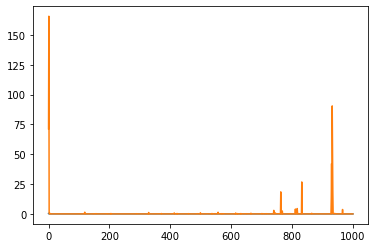

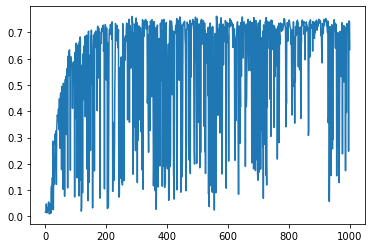

In [3]:

group_list=['A','B','C','D','E']







for group in group_list:
    print(group)
    


    parser = argparse.ArgumentParser()



    #バッチサイズの調整　3にしている

    parser.add_argument(
        "-b", "--batch_size", dest="batch_size", help="batch_size", default=3, type=int
    )
    parser.add_argument(
        "-e", "--epochs", dest="epochs", help="epochs", default=1000, type=int
    )
    parser.add_argument(
        "-l",
        "--learning_rate",
        dest="learning_rate",
        help="learning late",
        default=1e-3,
        type=float,
    )

    parser.add_argument(
        "-g",
        "--gpu",
        dest="gpu",
        help="whether use CUDA",
        default=True,
        action="store_true",
    )

    parser.add_argument(
        "-v",
        "--val_path",
        dest="val_path",
        help="validation data path",
        default=f"./data/σ=6/{group}=test/sarcoma_val",
        type=str,
    )

    parser.add_argument(
        "-i",
        "--img_path",
        dest="img_path",
        help="image data path",
        default=f"./data/σ=6/{group}=test/train_img_F",
        type=str,
    )
    parser.add_argument(
        "-w",
        "--weight_path",
        dest="weight_path",
        help="save weight path",
        default=f"./data/σ=6/{group}=test/weight_F/nuclei_sarcoma/best.pth",
    )
    
    parser.add_argument(
    "-w_F",
    "--weight_path_F",
    dest="weight_path_F",
    help="save weight path_F",
    default=f"./data/σ=6/{group}=test/weight_F/nuclei_sarcoma/best_F.pth",)

    parser.add_argument("-d",\
                        "--data_path",
                        dest="data_path",
        help="training dataset's path",
        default=f"./data/σ=6/{group}=test/sarcoma_train",
        type=str)

    args = parser.parse_args(args=["--data_path",f"./data/σ=6/{group}=test/sarcoma_train",
                                   "--val_path",f"./data/σ=6/{group}=test/sarcoma_val"])
    if __name__ == "__main__":


        img_paths = sorted(Path(args.data_path).joinpath("ori").glob("*.*"))
        gt_paths = sorted(Path(args.data_path).joinpath("likeli").glob("*.*"))


        img_paths_val = sorted(Path(args.val_path).joinpath("ori").glob("*.*"))
        gt_paths_val = sorted(Path(args.val_path).joinpath("likeli").glob("*.*"))

        # split train and validation
        idx_list = list(range(len(img_paths)))
        random.shuffle(idx_list)



        args.tra_img_paths = img_paths
        args.tra_gt_paths = gt_paths

        args.val_img_paths = img_paths_val
        args.val_gt_paths = gt_paths_val

        args.weight_path = Path(args.weight_path)
        
        model = smp.Unet(
    encoder_name="resnet34",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",  # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,  # model output channels (number of classes in your dataset)
)

        net = model


        if args.gpu:
            net.cuda()



        args.net = net

        train = TrainNet(args)

        loss,val_loss, val_F=train.main()
        save_history(loss,val_loss, os.path.join(args.img_path, 'loss.txt'))
        
        save_history_F(val_F, os.path.join(args.img_path, 'val_F.txt'))